# Classification Metric : Development & Test

## General

### Imports

In [1]:
import pyvdirs.dirs as dirs
import sys
import os
sys.path.insert(0, dirs.SYSTEM_HOME)
sys.path.insert(0, os.path.join(dirs.SYSTEM_HOME, "ToyExample"))

import copy
import pickle
import builtins
import numpy as np
import torch
import matplotlib.pyplot as plt
import pyvtools.text as vtext
import math

import ToyExample.toy_example as toy
import mandala_exploration.fractal_step_by_step as mand
import utils

%load_ext autoreload
%autoreload 2

### Parameters

In [2]:
# Network parameters
classes='A'
num_layers=4
hidden_dim=64
batch_size=4<<10
total_iter=4<<10

# Distribution parameters
P_mean=-2.3
P_std=1.5
sigma_data=0.5
sigma_max=5
lr_ref=1e-2
lr_iter=512
ema_std=0.010

# Guidance parameters
guidance=False
guidance_weight=3
guide_path=os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", "Ref", "iter0512.pkl")
guide_interpolation=False

# ACID parameters
acid=False
acid_n=16
acid_f=0.8
acid_diff=True
acid_inverted=False

# Training parameters
val_batch_size=4<<7
test_batch_size=4<<8

# Other parameters
device=torch.device('cuda')
fig1_kwargs = dict(view_x=0.30, view_y=0.30, view_size=1.2, device=device)
fig2_kwargs = dict(view_x=0.45, view_y=1.22, view_size=0.3, device=device)#, sample_distance=0.045, sigma_max=0.03)
seed=0

In [3]:
# Set random seed, if specified
if seed is not None:
    print("Seed = ", seed)
    torch.manual_seed(seed)
    generator = torch.Generator(device).manual_seed(seed)
    np.random.seed(seed)

Seed =  0


In [4]:
# Initialize models
gtd, gtd_comps = toy.gt(classes, device)
net = toy.ToyModel(num_layers=num_layers, hidden_dim=hidden_dim, sigma_data=sigma_data).to(device).train().requires_grad_(True)
ema = copy.deepcopy(net).eval().requires_grad_(False)
opt = torch.optim.Adam(net.parameters(), betas=(0.9, 0.99))
if guide_path is not None:
    with builtins.open(guide_path, "rb") as f:
        guide = pickle.load(f).to(device)
    print("Guide model loaded")
else:
    guide = None
if guidance and acid:
    ref = guide
    print("Guide model assigned as ACID reference")
elif acid: 
    ref = ema
    print("EMA assigned as ACID reference")
else: ref = None

Guide model loaded


## Plots

In [6]:
print("Original threshold for logp is set to", -2.12, "meaning probability density of", math.exp(-2.12))

Original threshold for logp is set to -2.12 meaning probability density of 0.12003162851145673


In [7]:
gtd_comps

[{'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.02134411, 0.06333431]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.05188869, 0.09552517]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.08243328, 0.12771604]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.11297786, 0.1599069 ]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.14352244, 0.19209777]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.17406703, 0.22428864]),
  'Sigma': array

Point (x,y) : log(PDF(x,y)) : PDF(x,y)
(0.3, 0.3) : 2.0693705081939697 : 7.9198360764480915
(0.2, 0.2) : 0.48671233654022217 : 1.6269585255381334
(0.3, 0.2) : -16.56256103515625 : 6.411669624112501e-08
(0.4, 0.2) : -3.1475229263305664 : 0.042958406318854316
(0.3, 0.1) : -56.93898391723633 : 1.8694483878925558e-25


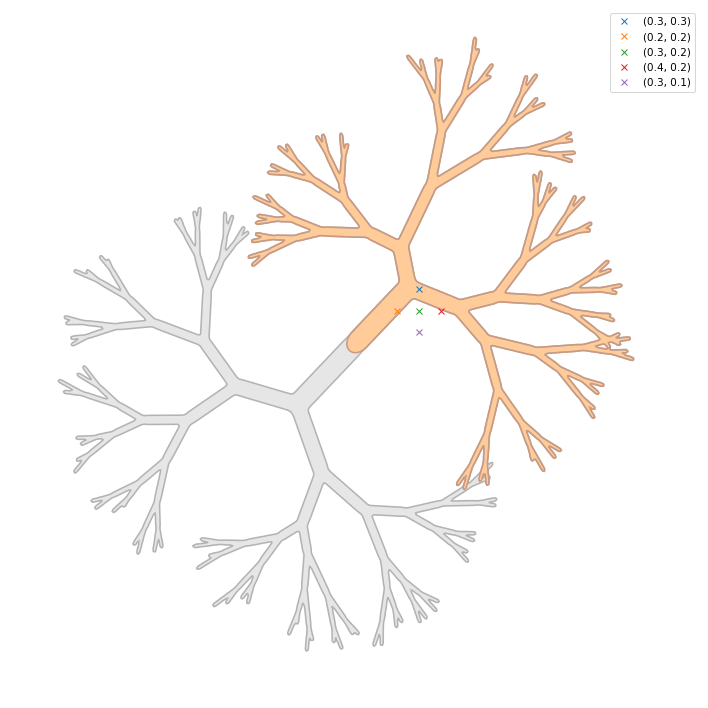

In [ ]:
points = [(.3,.3), (.2,.2), (.3,.2), (.4,.2), (.3,.1)]

fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'gt_uncond', 'gt_outline'}, ax=ax, device=device)
print("Point (x,y) : log(PDF(x,y)) : PDF(x,y)")
for p in points:
    gt_logp = float(gtd.logp(torch.Tensor(p).reshape((1,2)).to(device)))
    print(p, ":", gt_logp, ":", math.exp(gt_logp))
    plt.plot(*p,"x",label=str(p))
plt.legend()

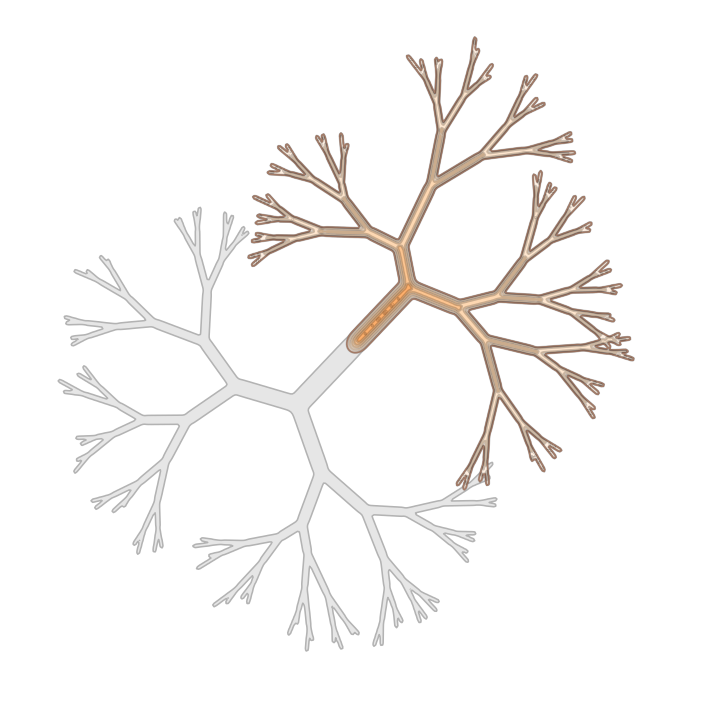

In [10]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'gt_uncond', 'gt_outline', 'gt_shaded'}, ax=ax, device=device)

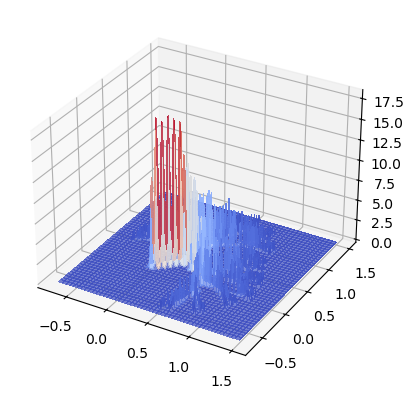

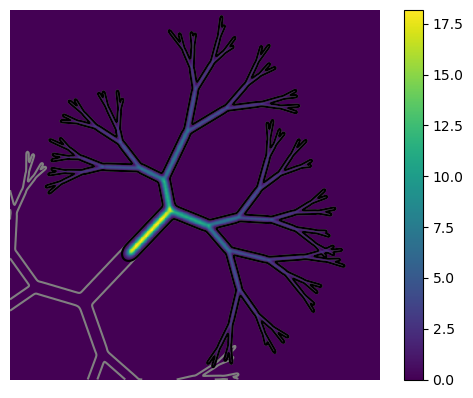

In [ ]:
grid_resolution = 801
zoom_out = 1

x_centre = .4
y_centre = .4
y_side = x_side = 2*1.1

samples = utils.create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)
f_samples = gtd.pdf(samples)

samples = samples.swapaxes(0,2).swapaxes(1,2).cpu().numpy()
f_samples = f_samples.detach().cpu().numpy()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(*samples, f_samples, cmap="coolwarm", 
                linewidth=0, antialiased=False, alpha=0.7)

fig, ax = plt.subplots()
plt.pcolormesh(*samples, f_samples)
ax.set_aspect("equal")
plt.colorbar()
toy.do_plot(ema, elems={'gt_uncond_transparent', 'gt_outline_transparent'}, ax=ax, 
            view_x=x_centre, view_y=y_centre, view_size=x_side/2)

## Old plots

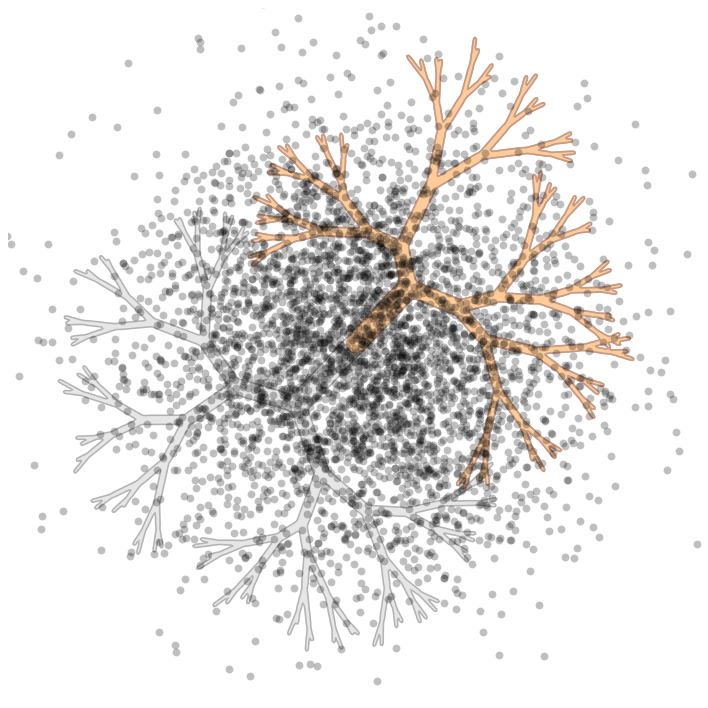

In [12]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'samples','gt_uncond', 'gt_outline'}, ax=ax,
            sigma_max=sigma_max, device=device, num_samples=1<<12)

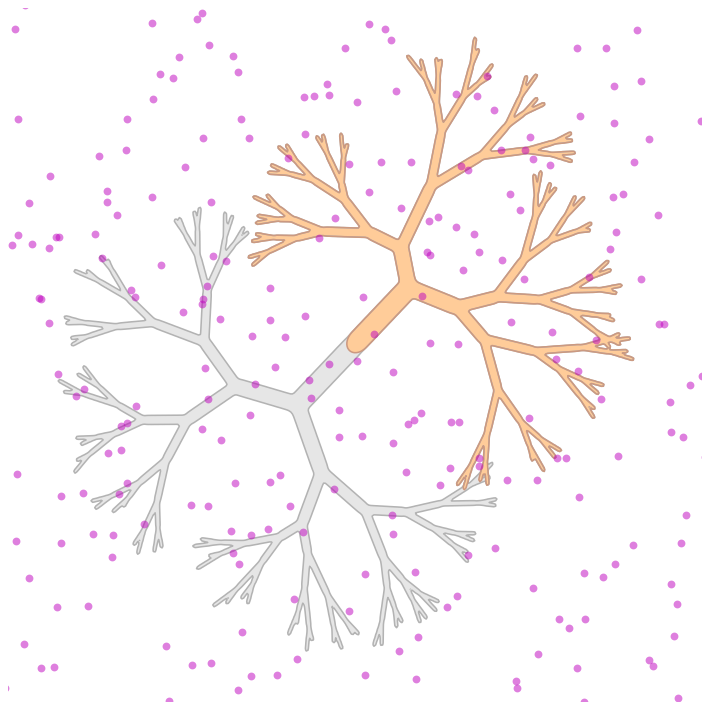

In [13]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'samples_before_small','gt_uncond', 'gt_outline'}, ax=ax, num_samples=1<<12)

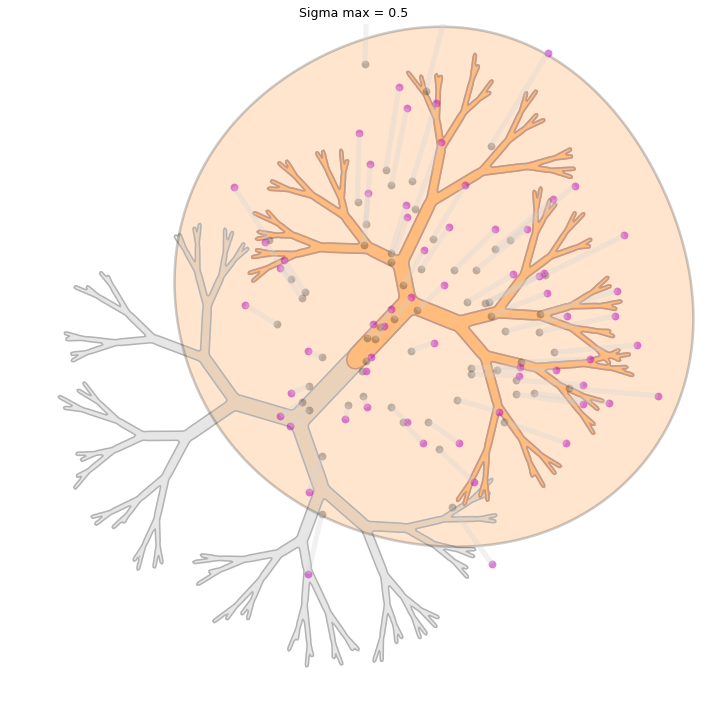

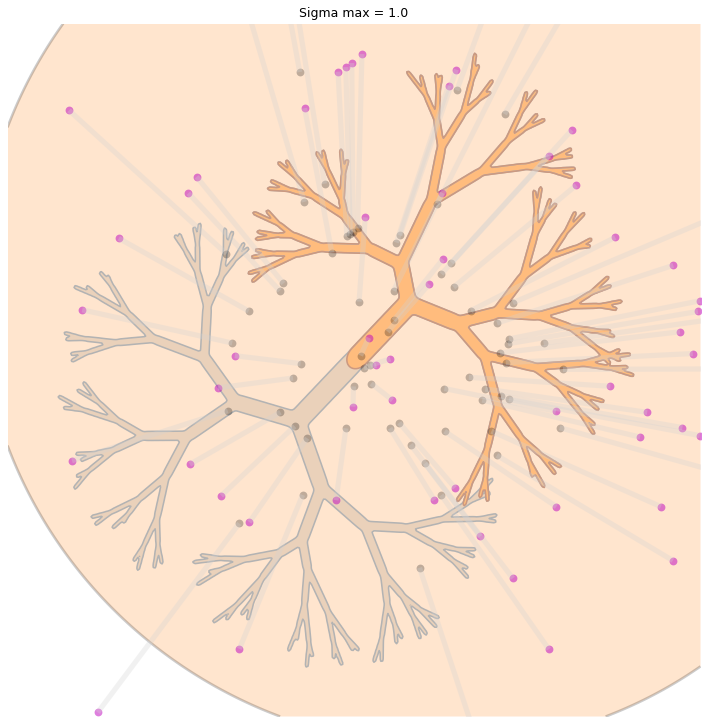

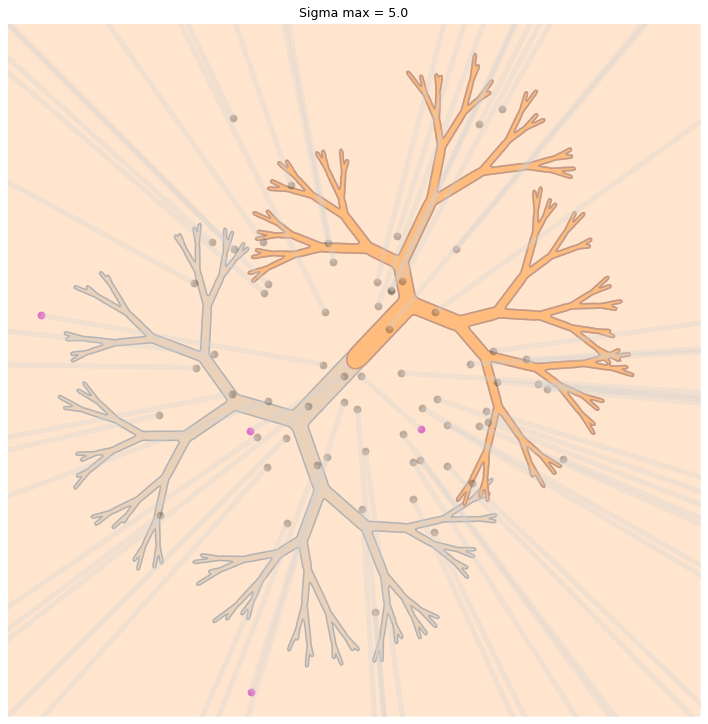

In [14]:
for sigma_max in [0.5,1,5]:
    fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
    toy.do_plot(ema, elems={'samples_before_small',
                            'trajectories_small', 'samples',
                            'gt_smax',
                            'gt_uncond', 'gt_outline'}, 
                num_samples=1<<6, sigma_max=sigma_max, ax=ax)
    plt.title(f"Sigma max = {sigma_max:.1f}")

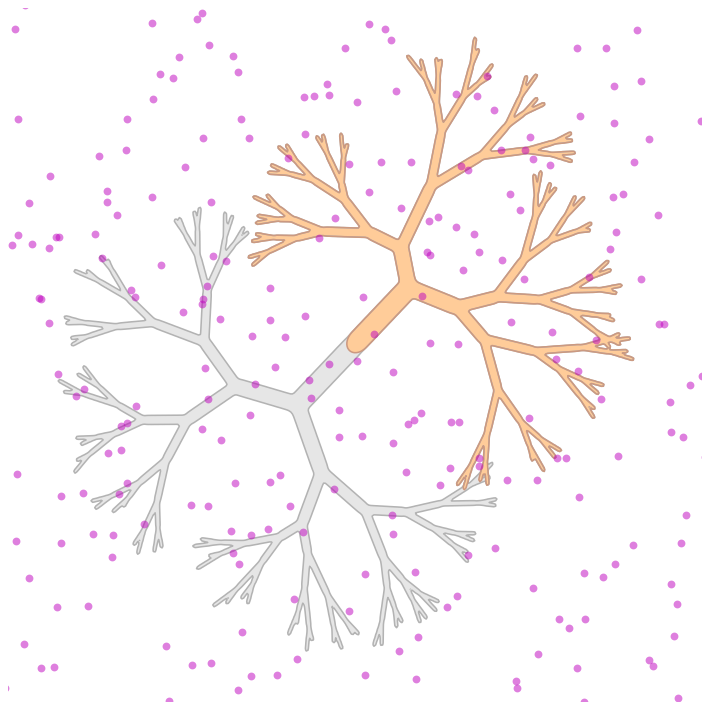

In [16]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'samples_before_small','gt_uncond', 'gt_outline'}, num_samples=1<<12, ax=ax)

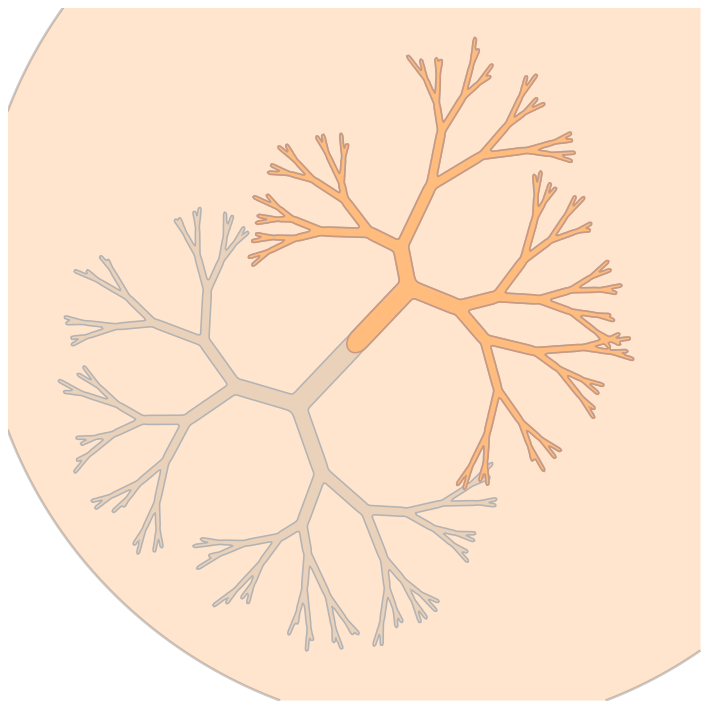

In [17]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'gt_smax','gt_uncond', 'gt_outline'}, num_samples=1<<12, sigma_max=1, ax=ax)

## Mandala score

In [16]:
def mandala_score(model, ground_truth_dist, sigma=0, n_samples=500,
                  grid_resolution=101, 
                  x_centre=toy.GT_ORIGIN[0], y_centre=toy.GT_ORIGIN[1], 
                  x_side=2*1.5, y_side=2*1.5,
                  logging=False, plotting=True):

    # Create grid
    grid_coords = utils.create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)
    cell_size, bounds = utils.get_grid_params(grid_resolution, x_centre, y_centre, x_side, y_side)
    cell_size = cell_size[0] # Squared symmetric grid ==> Retain just one
    bounds = (*bounds[0], *bounds[1])
    x_edges = np.linspace(bounds[0], bounds[1], grid_resolution + 1)
    y_edges = np.linspace(bounds[2], bounds[3], grid_resolution + 1)

    # Create samples
    samples = model.sample(n_samples, sigma=sigma)

    # Count hits and misses
    hit_samples_mask = utils.is_sample_in_fractal(samples, ground_truth_dist)
    n_hits = int(torch.sum(hit_samples_mask))
    n_miss = n_samples - n_hits
    if logging: print("Total", n_samples, "\n> Hits", n_hits, "\n> Misses", n_miss)
    hit_samples = samples[hit_samples_mask]
    miss_samples = samples[torch.logical_not(hit_samples_mask)]

    # Get grid coordinates for hits and misses
    hit_cells = np.array( mand.point_to_cell( hit_samples, bounds[0], bounds[2], cell_size ), dtype=np.int32 ).T
    miss_cells = np.array( mand.point_to_cell( miss_samples, bounds[0], bounds[2], cell_size ), dtype=np.int32 ).T

    # Register hits and missess in a plottable grid
    grid = np.zeros((grid_resolution, grid_resolution))
    for cell in hit_cells: grid[*cell] += 1
    for cell in miss_cells: grid[*cell] -= 1

    # Get unique hits and misses
    hit_unique = set([(x,y) for x,y in hit_cells])
    miss_unique = set([(x,y) for x,y in miss_cells])
    n_hits_unique = len(hit_unique)
    n_miss_unique = len(miss_unique)
    n_unique = n_hits_unique+n_miss_unique
    if logging: print("Unique total", n_unique, "\n> Unique hits", n_hits_unique, "\n> Unique misses", n_miss_unique)

    # Calculate metric    
    mandala_score = n_hits_unique / n_unique if n_unique > 0 else 0
    if logging: print("Mandala score", mandala_score)    

    if plotting:
            
        # Create figure with square aspect ratio
        plt.figure(figsize=(10, 5), dpi=300)

        # 1. Draw fractal with scatter
        ax1 = plt.subplot(121, aspect='equal')
        ax1.set_title("Fractal Tree with Scatter")

        # Draw fractal
        toy.do_plot(ema, elems={'gt_uncond', 'gt_outline'},
                    view_x=x_centre, view_y=y_centre, view_size=x_side/2, ax=ax1)

        # Plot scatter points
        ax1.scatter(*samples.swapaxes(0,1).detach().cpu().numpy(), color='k', alpha=0.1, s=10, zorder=10)

        # 2. Hit/Miss Visualization
        ax2 = plt.subplot(122, aspect='equal')
        ax2.set_title("Hit/Miss Analysis")

        ax2.pcolormesh(*grid_coords.swapaxes(0,2).detach().cpu().numpy(), 
                    grid, cmap="seismic", 
                    vmin=-max(abs(grid.min()), abs(grid.max())), 
                    vmax=max(abs(grid.min()), abs(grid.max())), 
                    alpha=1)
        toy.do_plot(ema, elems={'gt_uncond_thin', 'gt_outline_thin'},
                    view_x=x_centre, view_y=y_centre, view_size=x_side/2, ax=ax2)

        # Add thin grid lines
        for x in x_edges:
            ax2.axvline(x=x, color='gray', alpha=0.2, linewidth=0.1)
        for y in y_edges:
            ax2.axhline(y=y, color='gray', alpha=0.2, linewidth=0.1)

        # Set bounds and remove axis numbers for all plots
        for ax in [ax1, ax2]:
            ax.set_xlim(bounds[0], bounds[1])
            ax.set_ylim(bounds[2], bounds[3])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        plt.tight_layout()

        # Add stats only to the last plot
        stats_text = f"Ground Truth: {n_unique}\nHits: {n_hits_unique}\nMisses: {n_miss_unique}\nMandala Score: {mandala_score:.3f}"
        ax2.text(0.02, 0.98, stats_text,
                    transform=ax2.transAxes,
                    verticalalignment='top',
                    fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return mandala_score

Total 500 
> Hits 499 
> Misses 1
Unique total 272 
> Unique hits 271 
> Unique misses 1
Mandala score 0.9963235294117647


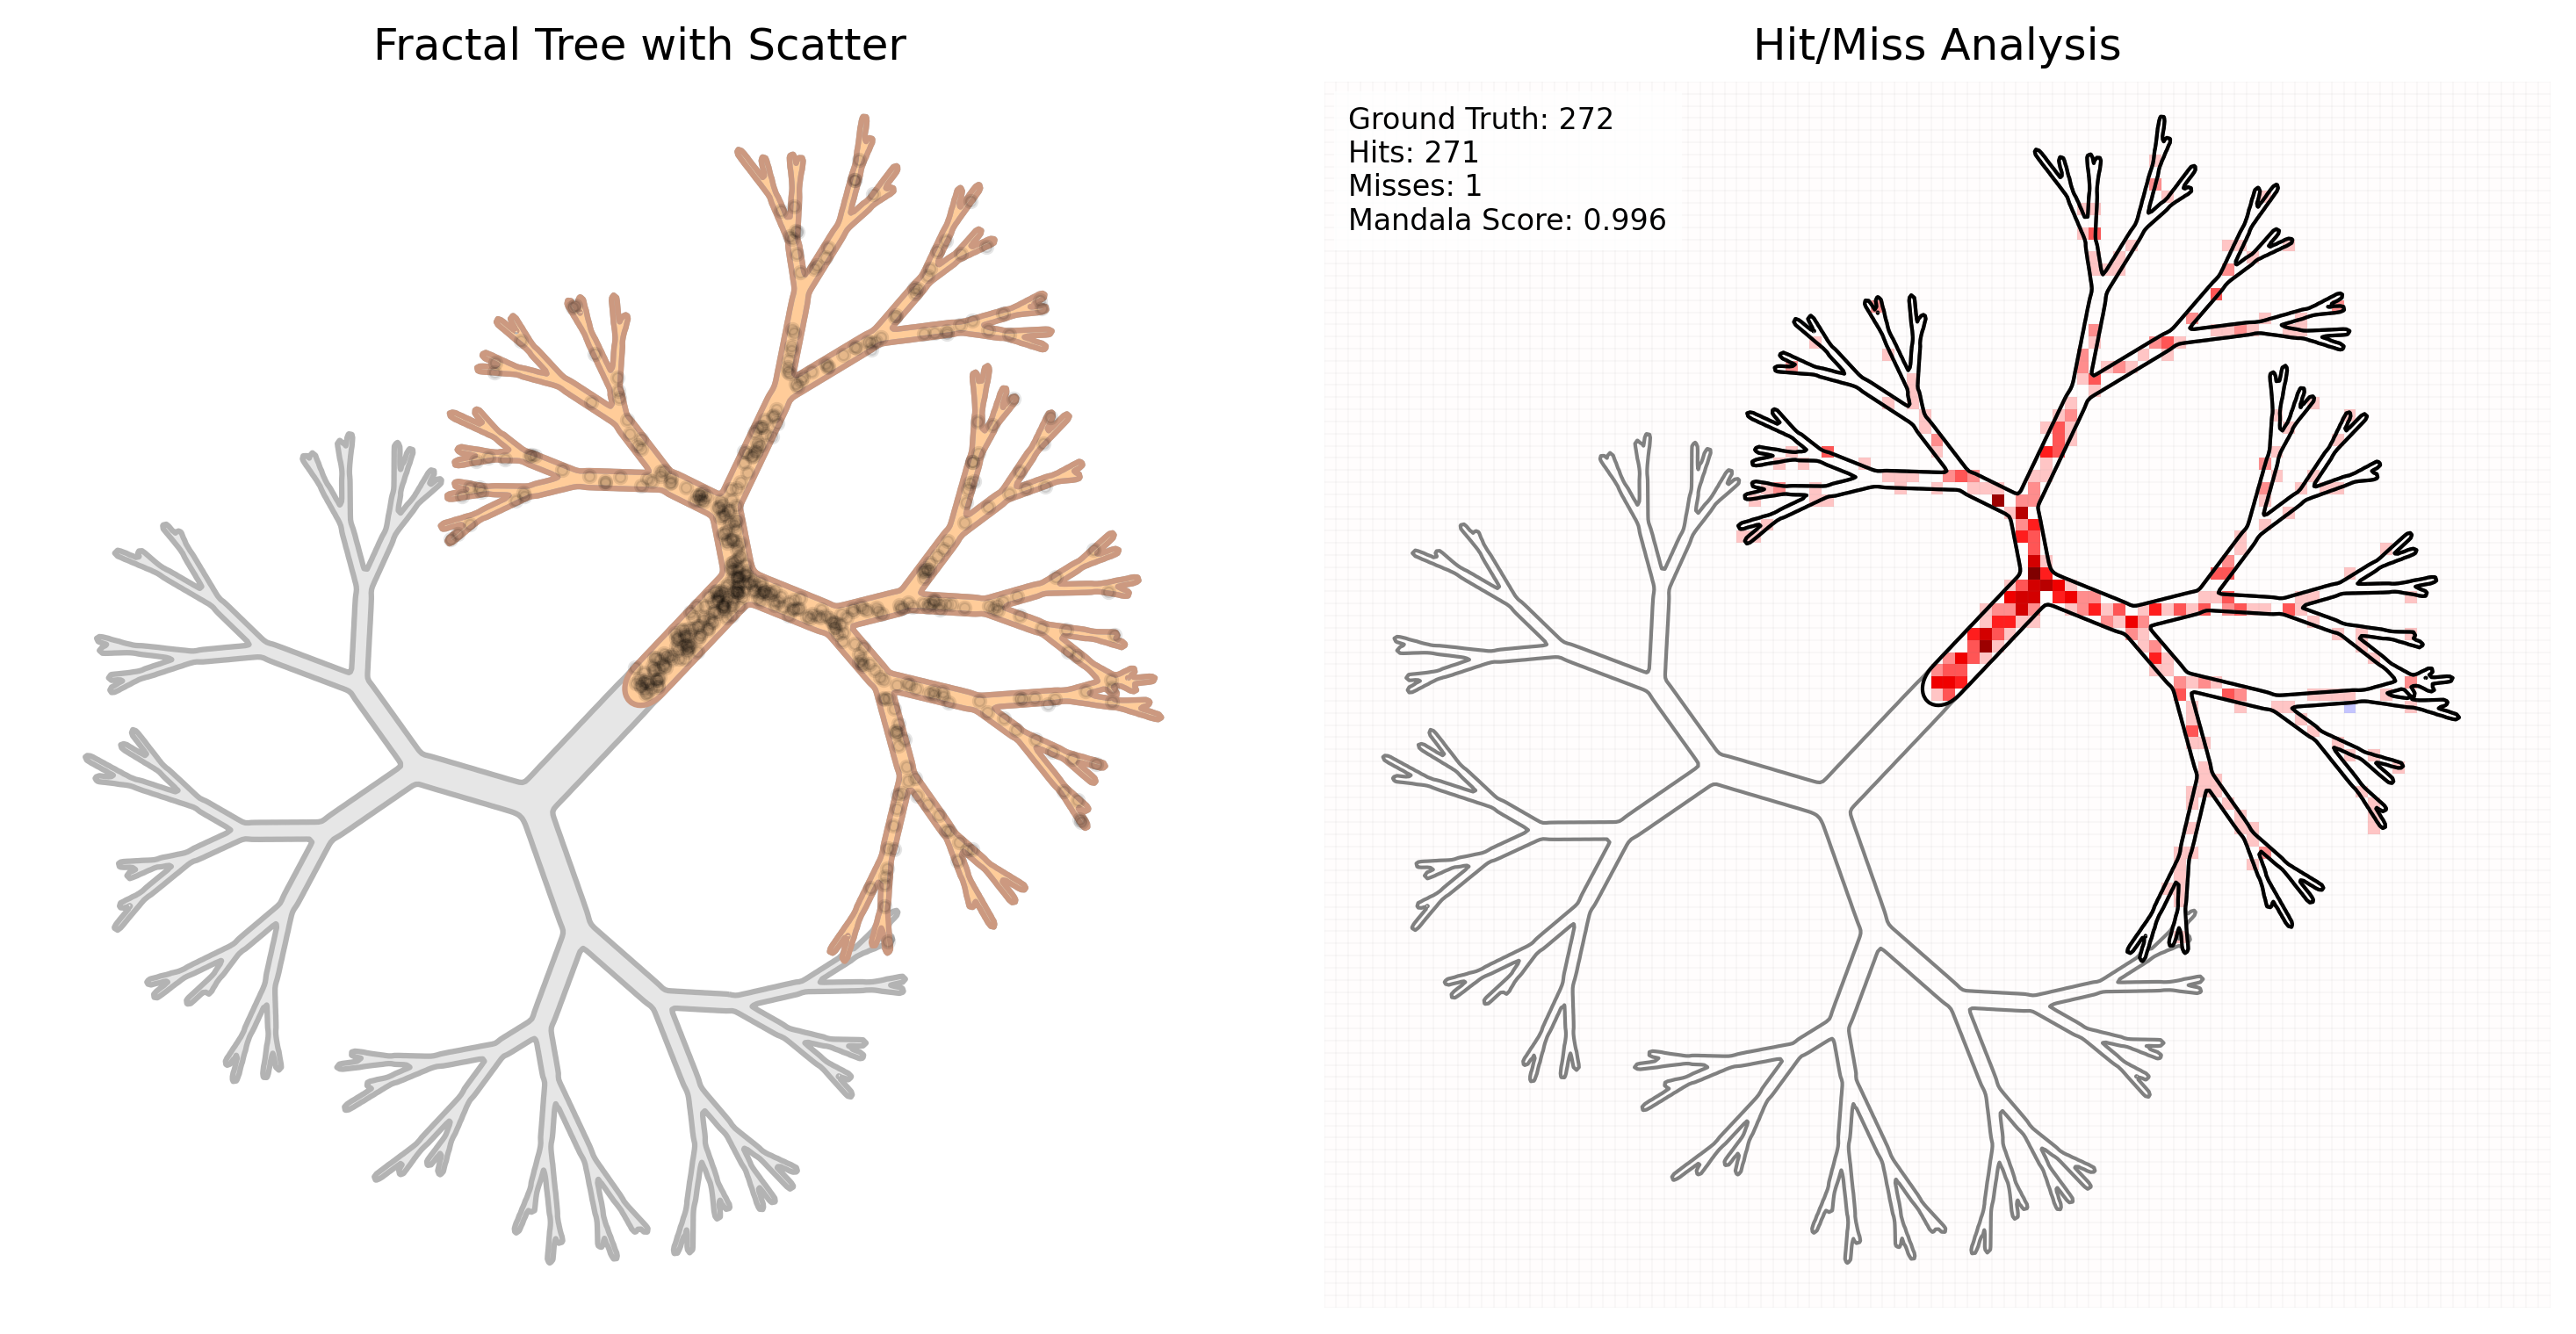

In [17]:
# Parameters
grid_resolution = 101
n_samples = 500

# Other parameters
x_centre, y_centre = toy.GT_ORIGIN
y_side = x_side = 2*1.5

mandala_score(gtd, gtd, 0, n_samples, grid_resolution, x_centre, y_centre, x_side, y_side, logging=True, plotting=True)
plt.savefig(os.path.join(dirs.RESULTS_HOME, 'fractal_analysis.png'), dpi=300, bbox_inches='tight')

In [10]:
# Parameters
grid_resolution = 101
n_samples = 500

# Other parameters
x_centre, y_centre = toy.GT_ORIGIN
y_side = x_side = 2*1.5

mandala_score(guide, gtd, sigma_max, n_samples, grid_resolution, x_centre, y_centre, x_side, y_side, logging=True, plotting=True)
plt.savefig(os.path.join(dirs.RESULTS_HOME, 'fractal_analysis.png'), dpi=300, bbox_inches='tight')

AttributeError: 'ToyModel' object has no attribute 'sample'